In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
logs_df_statistical_method = pd.read_csv("/content/drive/MyDrive/logs_df_statistical_method.csv")
logs_df_statistical_method.head()

,Unnamed: 0,request_processing_time,target_processing_time,response_processing_time,received_bytes,sent_bytes,number of requests
0,0,0.000,0.759,0.0,375,542,1
1,1,0.001,0.194,0.0,374,2363,5
2,2,0.001,0.444,0.0,374,542,7
3,3,0.000,0.221,0.0,375,5641,8
4,4,0.001,0.168,0.0,375,2532,8


In [9]:
logs_df_statistical_method.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
logs_df_statistical_method.shape

(100000, 6)

# Statistical model

Cutoff hi > 2 * (p + 1) / n was too small as all observations were marked as unusual. We will use hi > 3 * (p + 1) / n cutoff instead.

In [6]:
# statistical model unidimensional case
anomalies_features = list()
anomalies_indices = list()
for column in logs_df_statistical_method.columns:
    for i in tqdm(range(1, logs_df_statistical_method.shape[0])):
        if i == 1:
          current_mean = np.mean(logs_df_statistical_method[column][:2])
        else:
          current_mean = ((i - 1) * previous_mean + logs_df_statistical_method[column][i]) * 1/i
        leverage_statistic = 1/i + np.power(logs_df_statistical_method[column][i] - current_mean, 2) / (np.var(logs_df_statistical_method[column][:i]) * 1/i)
        if leverage_statistic > (3 * 2) / i: # hi > 3 * (p + 1) / n
            anomalies_features.append(column)
            anomalies_indices.append(i)
        previous_mean = current_mean

  0%|          | 0/99999 [00:00<?, ?it/s]<ipython-input-6-b8314c851986>:10: RuntimeWarning: divide by zero encountered in double_scalars
  leverage_statistic = 1/i + np.power(logs_df_statistical_method[column][i] - current_mean, 2) / (np.var(logs_df_statistical_method[column][:i]) * 1/i)
  0%|          | 0/99999 [00:00<?, ?it/s]<ipython-input-6-b8314c851986>:10: RuntimeWarning: invalid value encountered in double_scalars
  leverage_statistic = 1/i + np.power(logs_df_statistical_method[column][i] - current_mean, 2) / (np.var(logs_df_statistical_method[column][:i]) * 1/i)
100%|██████████| 99999/99999 [00:39<00:00, 2552.47it/s]


In [7]:
# analyzing the output
len(set(anomalies_indices))

99998

In [8]:
# analyzing the output
np.unique(np.array(anomalies_features), return_counts=True)

(array(['number of requests', 'received_bytes', 'request_processing_time',
        'response_processing_time', 'sent_bytes', 'target_processing_time'],
       dtype='<U24'),
 array([99998, 99994, 99933, 99627, 99987, 99967]))

Feature number_of_requests was not cause of any anomaly

In [9]:
# statistical model multidimensional case
anomalies_indices_md = list()
leverage_statistics = list()
design_matrix_product_inverse = np.linalg.inv(np.dot(np.transpose(logs_df_statistical_method.to_numpy()), logs_df_statistical_method.to_numpy()))
for i in tqdm(range(1, logs_df_statistical_method.shape[0])):
  leverage_statistic = np.dot(np.dot(np.transpose(logs_df_statistical_method.iloc[0].to_numpy()), design_matrix_product_inverse), logs_df_statistical_method.iloc[0].to_numpy())
  leverage_statistics.append(leverage_statistic)
  if leverage_statistic > (3 * (7)) / i: # hi > 3 * (p + 1) / n
    anomalies_indices_md.append(i)

100%|██████████| 99999/99999 [00:17<00:00, 5690.65it/s]


In [10]:
# analyzing the output
len(anomalies_indices_md)

0

In [11]:
set(anomalies_indices).intersection(set(anomalies_indices_md))

set()

In [12]:
len(set(anomalies_indices).difference(set(anomalies_indices_md)))

99998

# Probabilistic model

In [13]:
import math

In [14]:
# probabilistic model request_processing_time
# ARIMA(0, 0, 0) with constant 4 e-04
request_processing_time_anomalies = list(logs_df_statistical_method["request_processing_time"][abs(logs_df_statistical_method["request_processing_time"]) > 4 * pow(10, -4) + 2 * math.sqrt(2)].index)
len(request_processing_time_anomalies)

0

In [15]:
# probabilistic model response_processing_time
# ARIMA(5, 1, 0)
ar_params = [-0.8352, -0.6647, -0.4993, -0.3295, -0.1647]
diff_variance = np.var(logs_df_statistical_method["response_processing_time"].diff()[1:])
ar_variance = np.sum(np.square(ar_params))
expected_variance = diff_variance * (1 + ar_variance)
response_processing_time_anomalies = list(logs_df_statistical_method["response_processing_time"].diff()[1:][abs(logs_df_statistical_method["response_processing_time"].diff()[1:]) > 2 * math.sqrt(expected_variance)].index)
len(request_processing_time_anomalies)

0

In [16]:
# probabilistic model target_processing_time
# ARIMA(1, 1, 0) with drift
ar_params = [-0.4890]
diff_variance = np.var(logs_df_statistical_method["target_processing_time"].diff()[1:])
ar_variance = np.sum(np.square(ar_params))
expected_variance = diff_variance * (1 + ar_variance)
target_processing_time_anomalies = list(logs_df_statistical_method["target_processing_time"].diff()[1:][abs(logs_df_statistical_method["target_processing_time"].diff()[1:]) > 2 * math.sqrt(expected_variance)].index)
len(target_processing_time_anomalies)

4306

Text(0.5, 1.0, 'target_processing_time_anomalies anomalies plot')

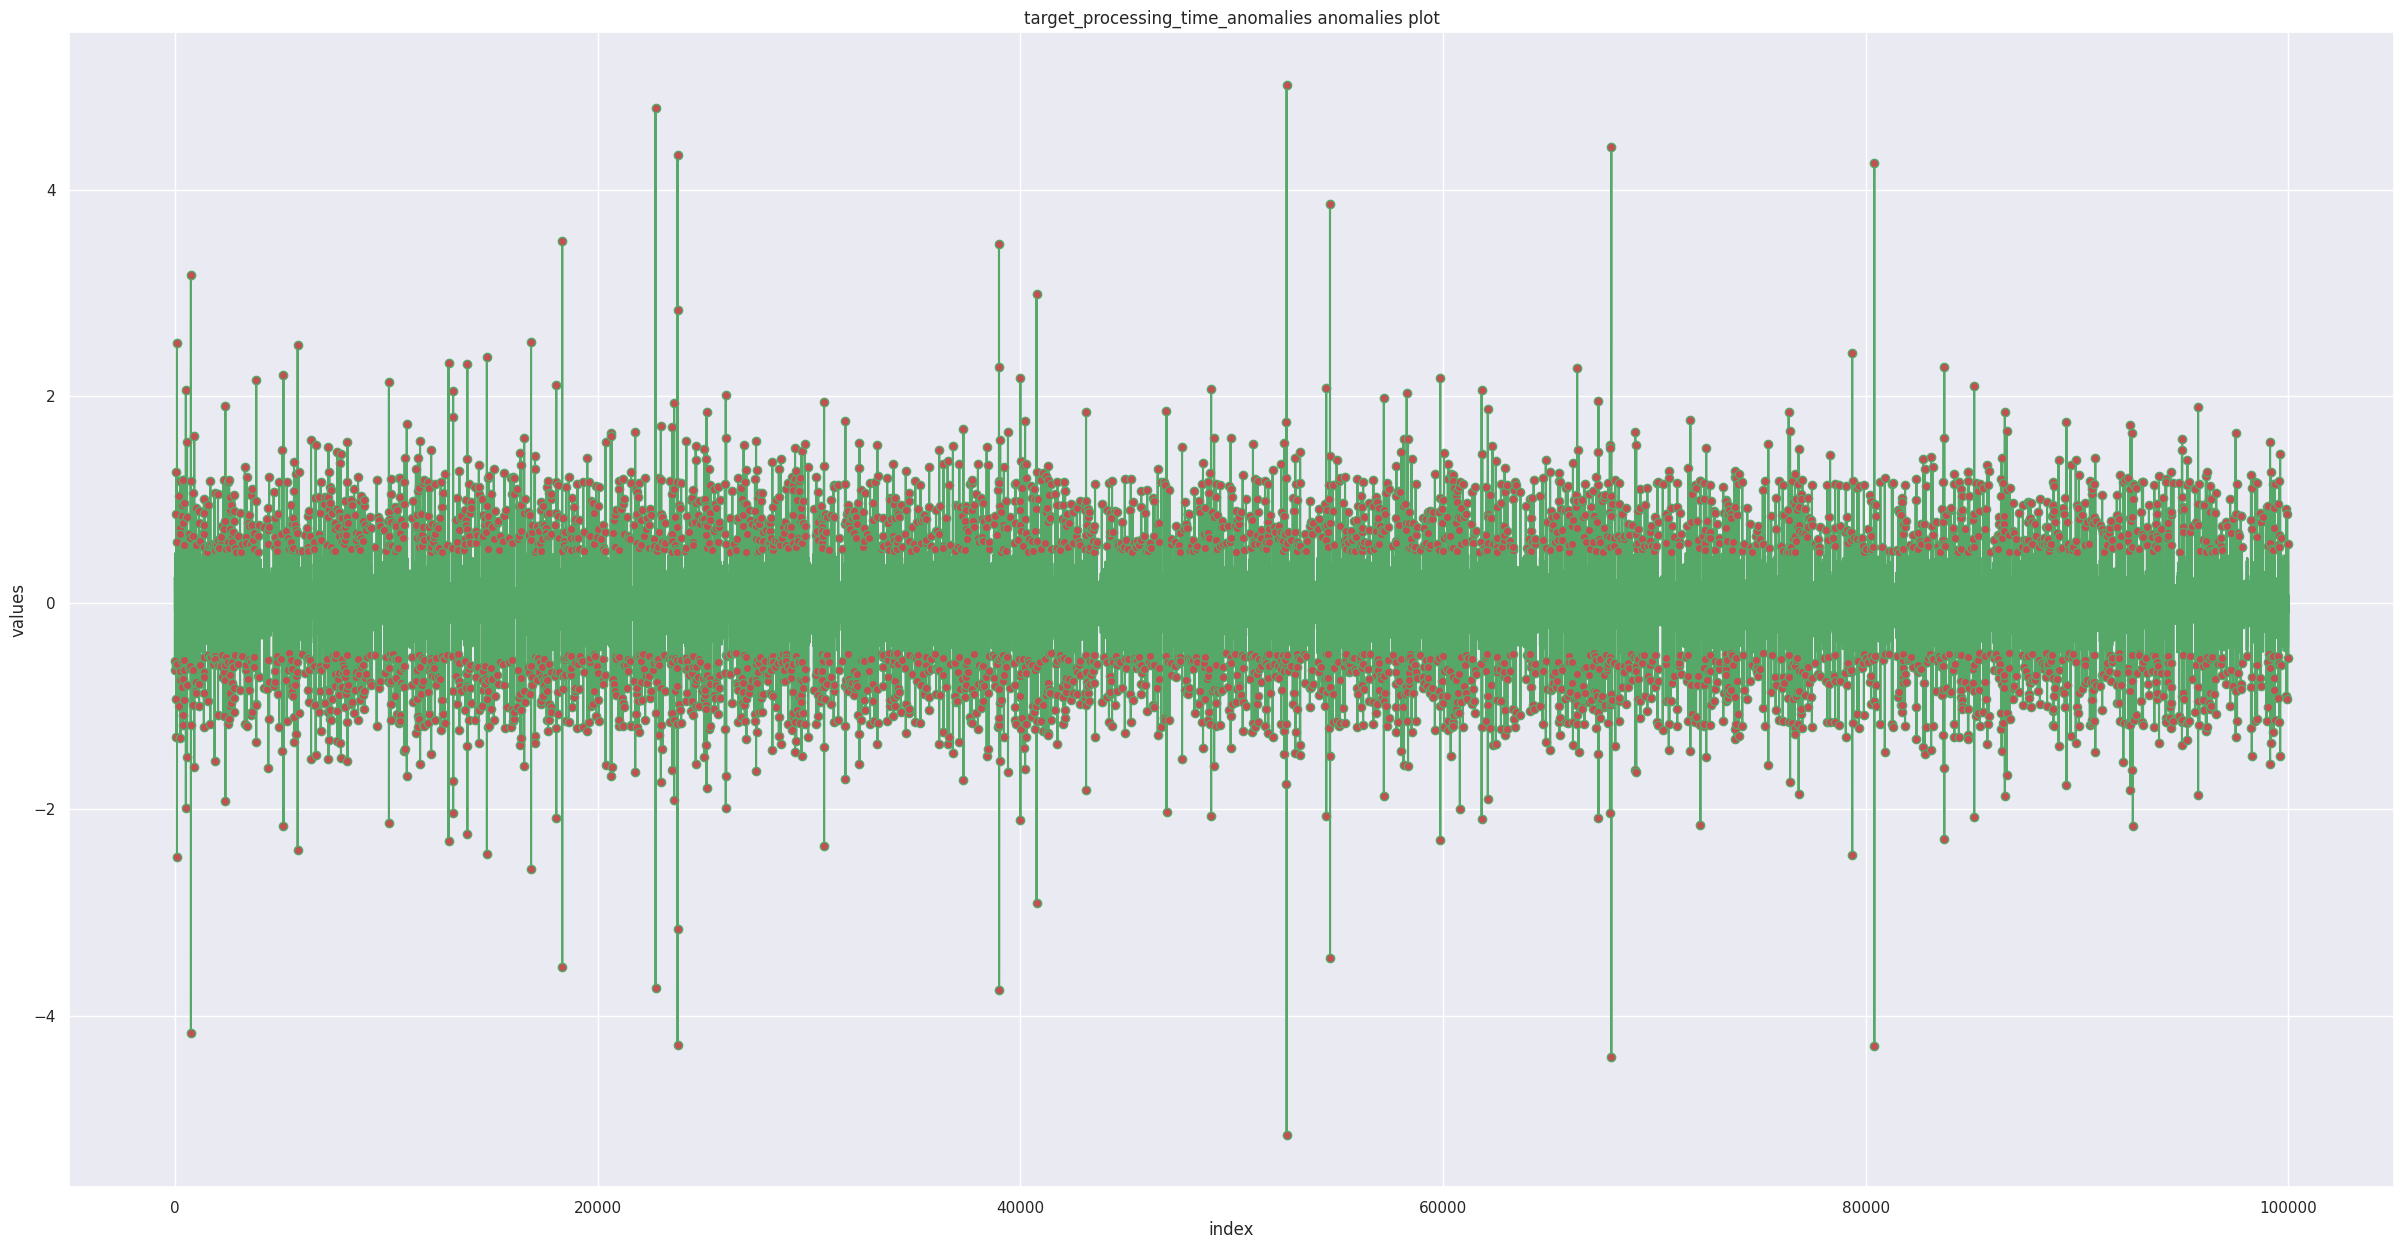

In [17]:
sns.set()
plt.figure(figsize=(30,15))
plt.plot(logs_df_statistical_method["target_processing_time"].diff().index, logs_df_statistical_method["target_processing_time"].diff(), '-go', markevery=target_processing_time_anomalies, markerfacecolor='r')
plt.xlabel('index')
plt.ylabel('values')
plt.title('target_processing_time_anomalies anomalies plot')

In [18]:
# probabilistic model received_bytes
# ARIMA(0, 1, 1)
received_bytes_anomalies = list((logs_df_statistical_method["received_bytes"].diff()[1:][abs(logs_df_statistical_method["received_bytes"].diff()[1:]) > 2 * math.sqrt(0.0099)]).index)
len(received_bytes_anomalies)

86763

Text(0.5, 1.0, 'received_bytes anomalies plot')

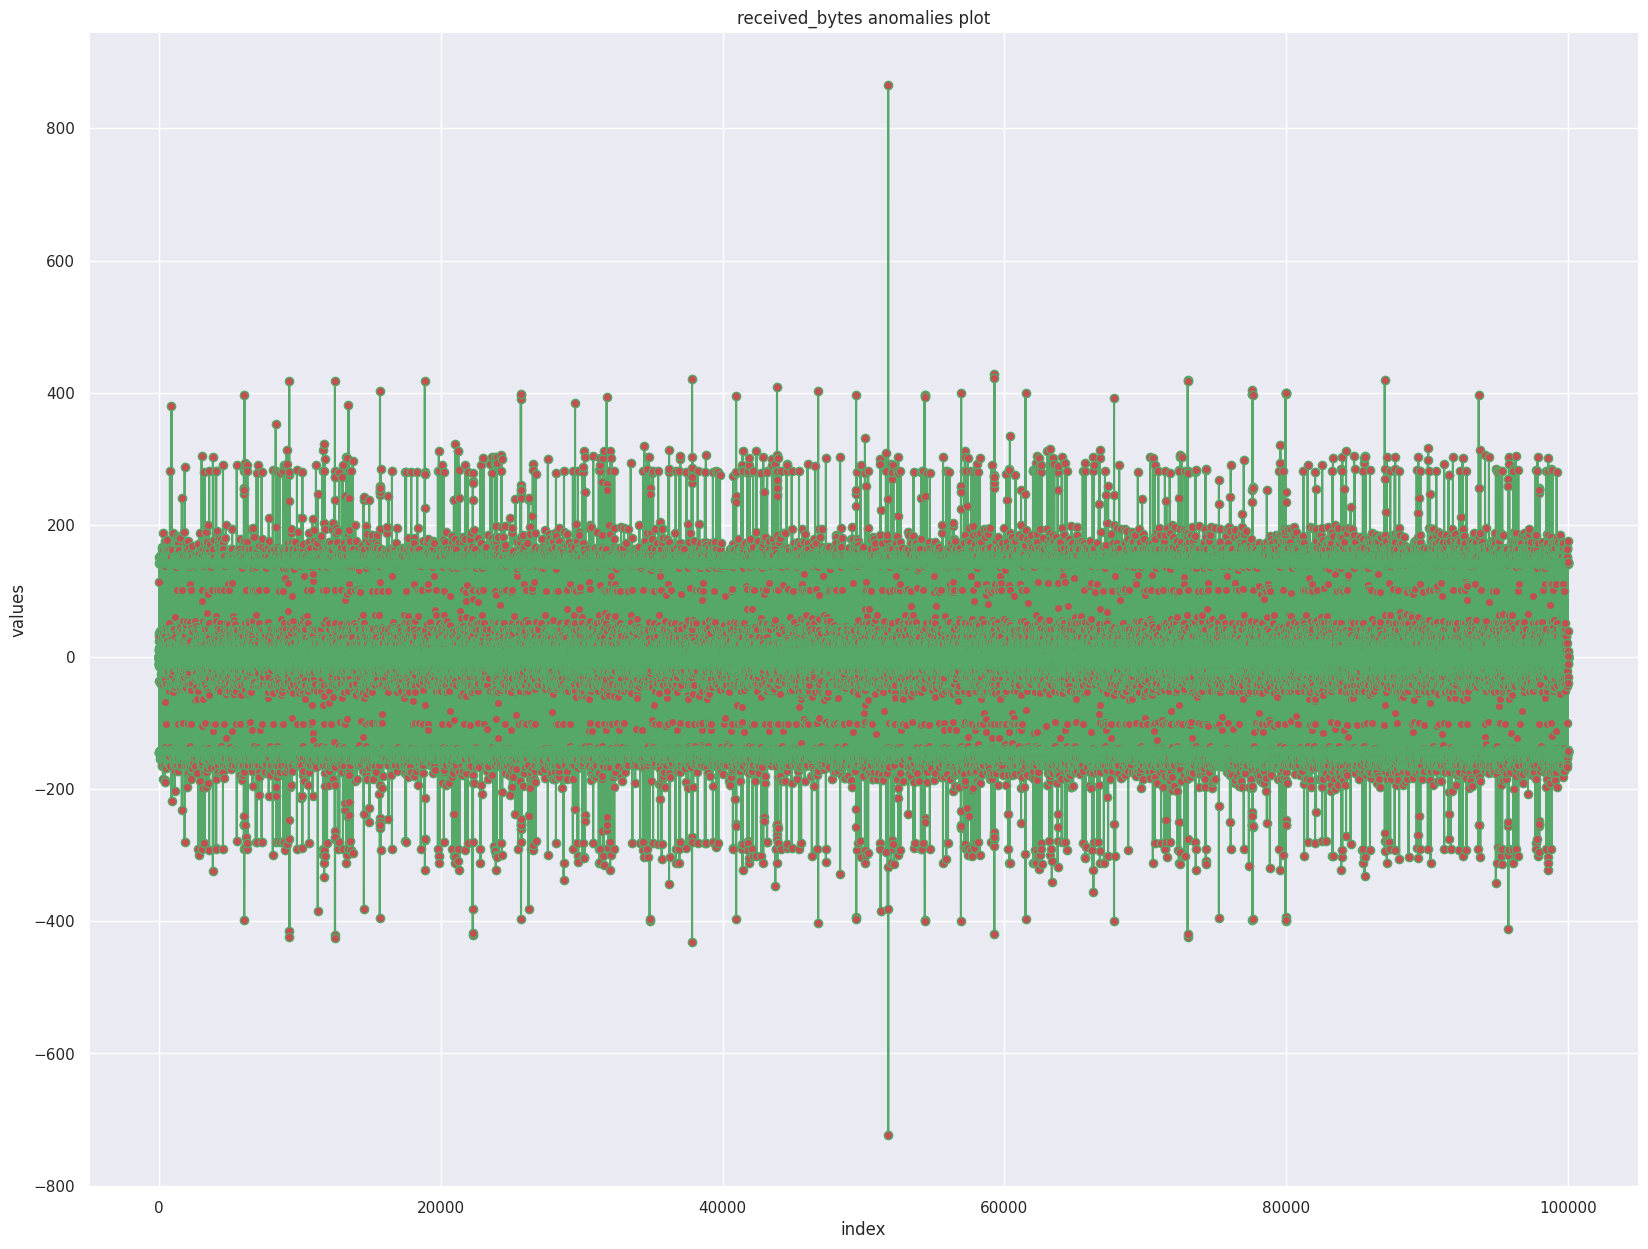

In [19]:
sns.set()
plt.figure(figsize=(20,15))
plt.plot(logs_df_statistical_method["received_bytes"].diff().index, logs_df_statistical_method["received_bytes"].diff(), '-go', markevery=received_bytes_anomalies, markerfacecolor='r')
plt.xlabel('index')
plt.ylabel('values')
plt.title('received_bytes anomalies plot')

In [20]:
# probabilistic model sent_bytes
# ARIMA(5, 1, 0)
ar_params = [-0.8340, -0.6716, -0.5020, -0.3341 -0.1659]
diff_variance = np.var(logs_df_statistical_method["sent_bytes"].diff()[1:])
ar_variance = np.sum(np.square(ar_params))
expected_variance = diff_variance * (1 + ar_variance)
sent_bytes_anomalies = list(logs_df_statistical_method["sent_bytes"].diff()[1:][abs(logs_df_statistical_method["sent_bytes"].diff()[1:]) > 2 * math.sqrt(expected_variance)].index)
len(sent_bytes_anomalies)

8

Text(0.5, 1.0, 'sent_bytes anomalies plot')

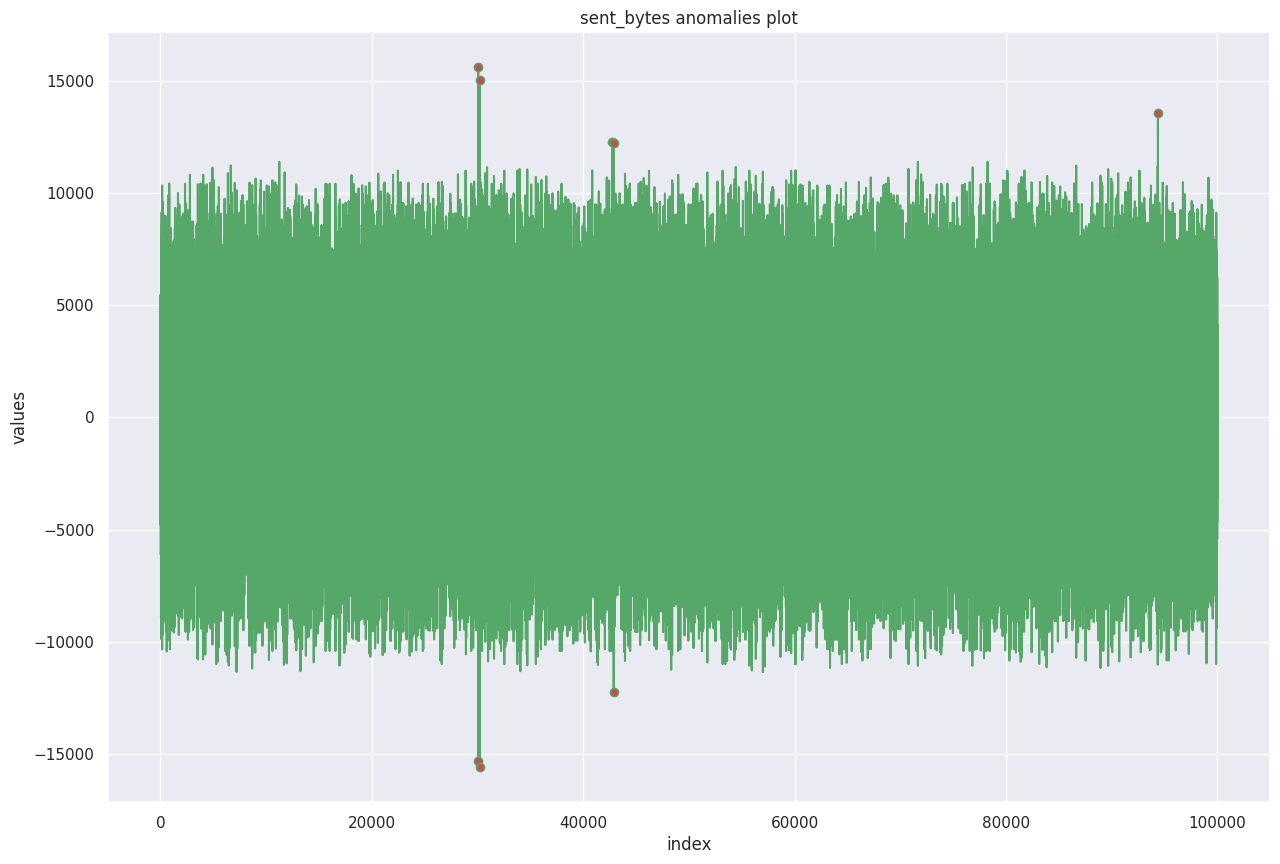

In [21]:
sns.set()
plt.figure(figsize=(15,10))
plt.plot(logs_df_statistical_method["sent_bytes"].diff().index, logs_df_statistical_method["sent_bytes"].diff(), '-go', markevery=sent_bytes_anomalies, markerfacecolor='r')
plt.xlabel('index')
plt.ylabel('values')
plt.title('sent_bytes anomalies plot')

In [3]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.4 MB/s eta 0:00:00


In [4]:
from fastparquet import ParquetFile
ohe_logs_df = ParquetFile('/content/drive/MyDrive/ohe_logs_df.parq')
ohe_logs_df = ohe_logs_df.to_pandas()

In [5]:
ohe_logs_df = ohe_logs_df.set_index("time")

# Deep LSTM network

In [6]:
import sklearn
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def generate_datasets_for_training(data, window_size, scale=True, scaler_type=StandardScaler):
  _l = len(data)
  data = scaler_type().fit_transform(data)
  Xs = []
  for i in tqdm(range(0, (_l - window_size))):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
    Xs.append(data[i:i+window_size])
  Xs = list(np.array(Xs).astype(np.float16))
  X_train, X_test, Y_train, Y_test = [np.array(x) for x in train_test_split(Xs, Xs)]
  return  (X_train.shape[2], X_train, Y_train, X_test, Y_test)

In [8]:
epochs = 100
batch_size = 32
window_length = 4
from keras import metrics
import keras
import tensorflow as tf
import os

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

feats, X_train, Y_train, X_test, Y_test = generate_datasets_for_training(ohe_logs_df, 4)

del ohe_logs_df # not needed here, only takes available RAM

model = keras.Sequential()
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3')) # return_sequences=False as next layer is keras.layers.RepeatVector
model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
model.compile(loss="mse", optimizer='adam')
model.build()
print(model.summary())

100%|██████████| 19996/19996 [00:00<00:00, 1584891.77it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 4, 64)             3289088   
                                                                 
 encoder_2 (LSTM)            (None, 4, 32)             12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Re  (None, 4, 16)             0         
 peatVector)                                                     
                                                                 
 decoder_1 (LSTM)            (None, 4, 16)             2112      
                                                                 
 decoder_2 (LSTM)            (None, 4, 32)             6272      
                                                        

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='LSTM_best_val_mse.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min')

In [10]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stop, checkpoint]) # we can shuffle as windows have been defined

Epoch 1/100
468/469 [============================>.] - ETA: 0s - loss: 0.9992
Epoch 1: val_loss improved from inf to 1.00060, saving model to LSTM_best_val_mse.h5
469/469 [==============================] - 29s 29ms/step - loss: 0.9991 - val_loss: 1.0006
Epoch 2/100
  5/469 [..............................] - ETA: 6s - loss: 1.0074

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - ETA: 0s - loss: 0.9987
Epoch 2: val_loss improved from 1.00060 to 1.00030, saving model to LSTM_best_val_mse.h5
469/469 [==============================] - 8s 16ms/step - loss: 0.9987 - val_loss: 1.0003
Epoch 3/100
466/469 [============================>.] - ETA: 0s - loss: 0.9982
Epoch 3: val_loss improved from 1.00030 to 1.00000, saving model to LSTM_best_val_mse.h5
469/469 [==============================] - 8s 16ms/step - loss: 0.9981 - val_loss: 1.0000
Epoch 4/100
469/469 [==============================] - ETA: 0s - loss: 0.9974
Epoch 4: val_loss improved from 1.00000 to 0.99968, saving model to LSTM_best_val_mse.h5
469/469 [==============================] - 8s 16ms/step - loss: 0.9974 - val_loss: 0.9997
Epoch 5/100
469/469 [==============================] - ETA: 0s - loss: 0.9966
Epoch 5: val_loss improved from 0.99968 to 0.99942, saving model to LSTM_best_val_mse.h5
469/469 [==============================] - 8s 16ms/step - loss: 0.9966 - v

Early stopping criterion stopped training after 6th epoch

In [11]:
best_model_LSTM = load_model('/content/LSTM_best_val_mse.h5')

In [12]:
def print_val_mse(model):
    val_mse = model.evaluate(X_test, Y_test, verbose = 1)
    print('Mse on test data: {}'.format(val_mse))

In [13]:
print_val_mse(best_model_LSTM)

157/157 [==============================] - 3s 7ms/step - loss: 0.9993
Mse on test data: 0.9992541670799255


In [14]:
def plot_history(hist_baseline, epochs):

    fig = plt.figure(figsize = (15, 10))
    metric = "loss"
    plt.title(metric.capitalize())
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.plot(range(1, 6 + 1), hist_baseline.history[metric], 'o-',
                 label="train", color = "tab:blue")
    plt.plot(range(1, 6 + 1), hist_baseline.history["val_" + metric], 'o-',
                 label="val", color = "tab:orange")
    plt.legend()

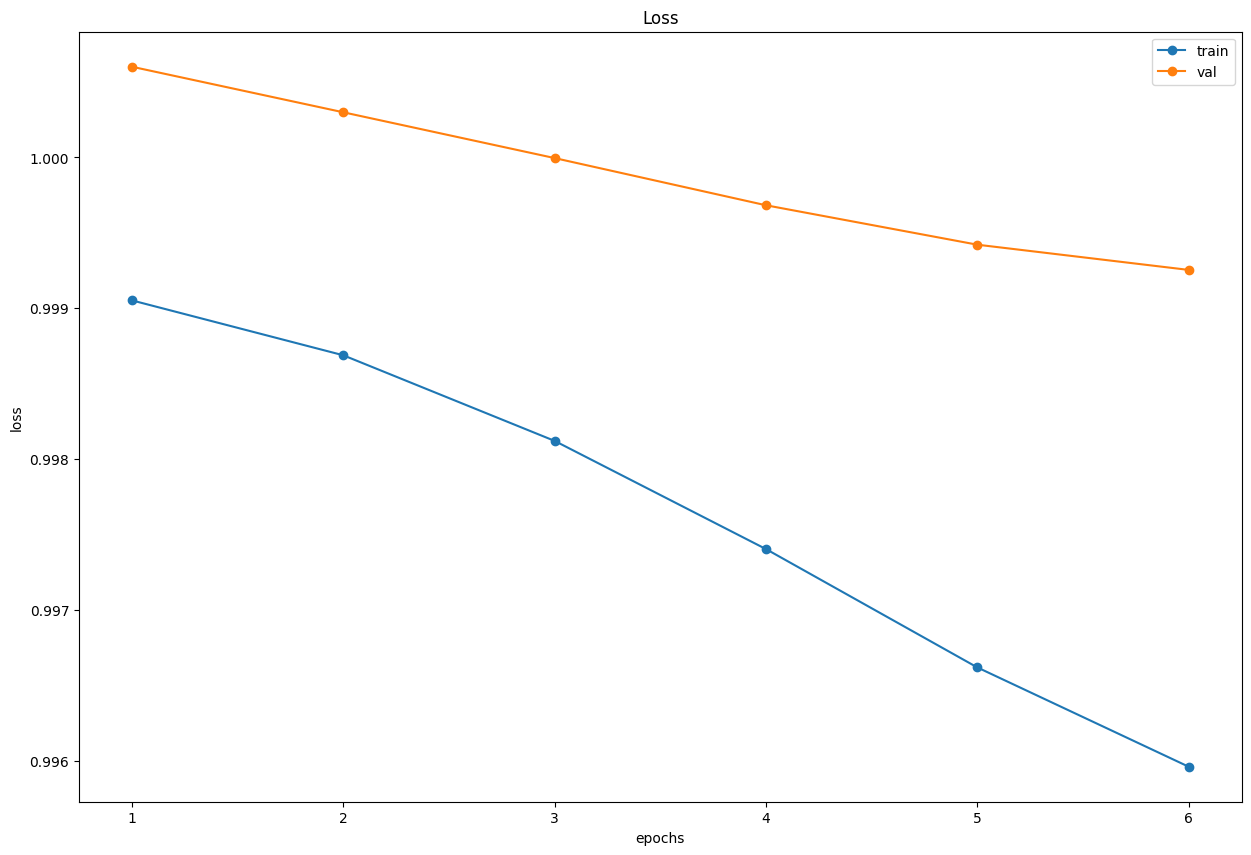

In [15]:
plot_history(history, epochs)

## Evaluation

In [3]:
from tensorflow.keras.models import load_model
best_model_LSTM = load_model('/content/drive/MyDrive/LSTM_best_val_mse.h5')

In [4]:
from sklearn.metrics import mean_squared_error

In [ ]:
'''X_train_mse = mean_squared_error(X_train, model.predict(X_train))
X_test_mse = mean_squared_error(X_test, model.predict(X_test))'''

In [5]:
!pip install fastparquet

from fastparquet import ParquetFile
ohe_logs_df_100000 = ParquetFile('/content/drive/MyDrive/ohe_logs_df_100000.parq')
ohe_logs_df_100000 = ohe_logs_df_100000.to_pandas()

ohe_logs_df_100000 = ohe_logs_df_100000.set_index("time")

window_size = 4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.0 MB/s eta 0:00:00


In [6]:
ohe_logs_df_100000.shape

(100000, 47759)

In [8]:
from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit_transform(ohe_logs_df_100000)

del ohe_logs_df_100000 # not anymore needed at this stage

Xs = list()
for i in tqdm(range(0, (len(data) - window_size))):
  Xs.append(data[i:i+window_size])

100%|██████████| 99996/99996 [00:00<00:00, 1193102.26it/s]


In [ ]:
mse_values = np.square(np.array(Xs).asarray(np.float16) - model.predict(np.array(Xs).asarray(np.float16)))

In [ ]:
'''import pickle

f = open('X_train_mse.pckl', 'wb')
pickle.dump(X_train_mse, f)
f.close()

f = open('X_test_mse.pckl', 'wb')
pickle.dump(X_test_mse, f)
f.close()'''